In [25]:
import numpy as np
import sklearn
import time
import random

# random forest
from sklearn.ensemble import RandomForestClassifier

#Calculate accuracy
from sklearn import metrics

#KNN
from sklearn.neighbors import KNeighborsClassifier

#AdaBoost
from sklearn.ensemble import AdaBoostClassifier

#SVM
from sklearn import svm

#Neural Nets
from sklearn.neural_network import MLPClassifier

#Naive Bayes
from sklearn.naive_bayes import GaussianNB

import pandas as pd

In [26]:
###############################################################################
# We have to use and MODIFY a lot the pre-processing method borrowed from another library to maximum our use of the dataset
# because it is a huge raw dataset and it is not in the form we need for our project. 
# https://github.com/llSourcell/Predicting_Winning_Teams
# Except for loading the data, everything else is orginal
# There will be a clear mark where our pure original code starts

In [27]:
# Read data and drop redundant column.
data = pd.read_csv('blfinal_dataset.csv')
data = data.filter(['FTR','HTP','ATP','HM1','HM2','HM3','AM1','AM2','AM3','HTGD','ATGD','DiffFormPts','DiffLP'], axis=1)

# Preview data.
display(data.head())


#Full Time Result (H=Home Win, D=Draw, A=Away Win)
#HTGD - Home team goal difference
#ATGD - away team goal difference
#HTP - Home team points
#ATP - Away team points
#DiffFormPts Diff in points
#DiffLP - Differnece in last years prediction

#Input - 12 other features (fouls, shots, goals, misses,corners, red card, yellow cards)
#Output - Full Time Result (H=Home Win, NH = Away win) 

,FTR,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffFormPts,DiffLP
0,H,0.0,0.0,M,M,M,M,M,M,0.0,0.0,0.0,-4.0
1,H,0.0,0.0,M,M,M,M,M,M,0.0,0.0,0.0,-5.0
2,H,0.0,0.0,M,M,M,M,M,M,0.0,0.0,0.0,4.0
3,NH,0.0,0.0,M,M,M,M,M,M,0.0,0.0,0.0,-1.0
4,NH,0.0,0.0,M,M,M,M,M,M,0.0,0.0,0.0,-13.0


In [28]:
#what is the win rate for the home team?

# Total number of matches.
n_matches = data.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(data[data.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print("Total number of matches: {}".format(n_matches))
print("Number of features: {}".format(n_features))
print("Number of matches won by home team: {}".format(n_homewins))
print("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 4896
Number of features: 12
Number of matches won by home team: 2288
Win rate of home team: 46.73%


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000271EB3FB240>,
      dtype=object)

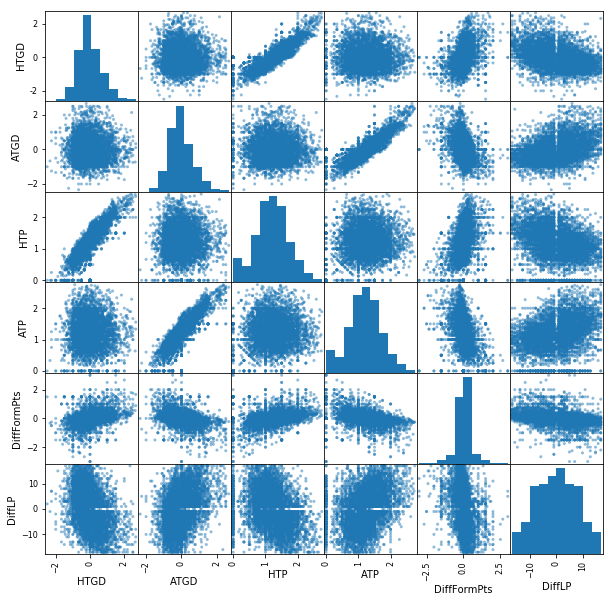

In [29]:
# Visualising distribution of data
from pandas.tools.plotting import scatter_matrix

#the scatter matrix is plotting each of the columns specified against each other column.
#You would have observed that the diagonal graph is defined as a histogram, which means that in the 
#section of the plot matrix where the variable is against itself, a histogram is plotted.

#Scatter plots show how much one variable is affected by another. 
#The relationship between two variables is called their correlation
#negative vs positive correlation

#HTGD - Home team goal difference
#ATGD - away team goal difference
#HTP - Home team points
#ATP - Away team points
#DiffFormPts Diff in points
#DiffLP - Differnece in last years prediction

scatter_matrix(data[['HTGD','ATGD','HTP','ATP','DiffFormPts','DiffLP']], figsize=(10,10))

In [30]:
# Separate into feature set and target variable
#FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
X_all = data.drop(['FTR'],1)
y_all = data['FTR']

# Standardising the data.
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
cols = [['HTGD','ATGD','HTP','ATP','DiffLP']]
for col in cols:
    X_all[col] = scale(X_all[col])

In [31]:
#last 3 wins for both sides
X_all.HM1 = X_all.HM1.astype('str')
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')
X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')

#we want continous vars that are integers for our input data, so lets remove any categorical vars
def preprocess_features(X):
    ''' Preprocesses the football data and converts catagorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (30 total features):
['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_M', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_M', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_M', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_M', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_M', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_M', 'AM3_W', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP']


In [32]:
############################################################################################################
#Here below is all original code

In [37]:
def AdaBoost_classifier(train_X,train_Y,test_X,test_Y):
    abc = AdaBoostClassifier(n_estimators=50)
    abc.fit(train_X,train_Y)
    trainAccuracy = abc.score(train_X,train_Y)
    pred = abc.predict(test_X)
    accuracy = metrics.accuracy_score(test_Y,pred)
    return accuracy,trainAccuracy
    
def RandomForest_classifier(train_X,train_Y,test_X,test_Y):
    
    clf=RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
    clf.fit(train_X,train_Y)
    trainAccuracy = clf.score(train_X,train_Y)
    y_pred = clf.predict(test_X)
    accuracy = metrics.accuracy_score(test_Y,y_pred)
    return accuracy, trainAccuracy

def SVM_classifier(train_X,train_Y,test_X,test_Y):
    clf = svm.SVC()
    clf.fit(train_X, train_Y)
    trainAccuracy = clf.score(train_X,train_Y)
    y_pred = clf.predict(test_X)
    accuracy = metrics.accuracy_score(test_Y,y_pred)
    return accuracy,trainAccuracy
    
def KNN_classifier(train_X,train_Y,test_X,test_Y):
    
    neigh = KNeighborsClassifier(n_neighbors=2)
    neigh.fit(train_X, train_Y)
    trainAccuracy = neigh.score(train_X,train_Y)
    y_pred = neigh.predict(test_X)
    accuracy = metrics.accuracy_score(test_Y,y_pred)
    return accuracy,trainAccuracy
    
def NeuralNets_classifier(train_X,train_Y,test_X,test_Y):
    
    clf = MLPClassifier(hidden_layer_sizes=(10, 3), learning_rate_init=0.0001,max_iter=200)
    clf.fit(train_X, train_Y)
    trainAccuracy = clf.score(train_X,train_Y)
    y_pred = clf.predict(test_X)
    accuracy = metrics.accuracy_score(test_Y,y_pred)
    return accuracy,trainAccuracy

def NaiveBayes_classifier(train_X,train_Y,test_X,test_Y):
    
    gnb = GaussianNB()
    gnb.fit(train_X, train_Y)
    trainAccuracy = gnb.score(train_X,train_Y)
    y_pred = gnb.predict(test_X)
    accuracy = metrics.accuracy_score(test_Y,y_pred)
    return accuracy,trainAccuracy
    

In [38]:
# Cross Validation # 80% 20%
from sklearn.model_selection import train_test_split

train_X, test_X,train_Y, test_Y = train_test_split(X_all,y_all,test_size=0.2)

accuracy_SVM = []
accuracy_AdaBoost = []
accuracy_RandomForest = []
accuracy_KNN = []
accuracy_NN = []
accuracy_NB = []

train_SVM = []
train_AdaBoost = []
train_RandomForest = []
train_KNN = []
train_NN = []
train_NB = []

for i in range(3):
        
        start_time = time.time()
        
        # AdaBoost Classifier
        testAccuracy1, trainAccuracy1 = AdaBoost_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_AdaBoost.append(testAccuracy1)
        train_AdaBoost.append(trainAccuracy1)

        time1 = time.time()
        if i == 1: 
            print("--- AdaBoost takes %s seconds ---" % (time1 - start_time))
            
            
        # RandomForest Classifier
        testAccuracy2,trainAccuracy2 = RandomForest_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_RandomForest.append(testAccuracy2)
        train_RandomForest.append(trainAccuracy2)
        
        time2 = time.time()
        if i== 1:
            print("--- RandomForest takes %s seconds ---" % (time2 - time1))
        
        # K-Nearest-Neighbour Classifier
        testAccuracy3,trainAccuracy3 = KNN_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_KNN.append(testAccuracy3)
        train_KNN.append(trainAccuracy3)
        
        time3 = time.time()
        if i== 1:
            print("--- KNN takes %s seconds ---" % (time3 - time2))
        
        #SVM classifier
        testAccuracy4, trainAccuracy4 = SVM_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_SVM.append(testAccuracy4)
        train_SVM.append(trainAccuracy4)
        
        time4 = time.time()
        if i==1:
            print("--- SVM takes %s seconds ---" % (time4 - time3))
        
        #Neural Nets classifier
        testAccuracy5,trainAccuracy5 = NeuralNets_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_NN.append(testAccuracy5)
        train_NN.append(trainAccuracy5)
        
        
        time5 = time.time()
        if i==1:
            print("--- Neural Nets takes %s seconds ---" % (time5 - time4))
            
        testAccuracy6,trainAccuracy6 = NaiveBayes_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_NB.append(testAccuracy6)
        train_NB.append(trainAccuracy6)
        
        time6 = time.time()
        if i==1:
            print("--- Naive Bayes takes %s seconds ---" % (time6 - time5))
        
print('TRAINING')        
print("Accuracy for AdaBoost:",np.mean(train_AdaBoost))
print("Accuracy for RandomForest:",np.mean(train_RandomForest))
print("Accuracy for KNN:",np.mean(train_KNN))
print("Accuracy for svm:",np.mean(train_SVM))
print("Accuracy for Neural Nets:",np.mean(train_NN))
print("Accuracy for Naive Bayes:",np.mean(train_NB))


print('TESTING')
print("Accuracy for AdaBoost:",np.mean(accuracy_AdaBoost))
print("Accuracy for RandomForest:",np.mean(accuracy_RandomForest))
print("Accuracy for KNN:",np.mean(accuracy_KNN))
print("Accuracy for svm:",np.mean(accuracy_SVM))
print("Accuracy for Neural Nets:",np.mean(accuracy_NN))
print("Accuracy for Naive Bayes:",np.mean(accuracy_NB))


C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


--- AdaBoost takes 0.6293778419494629 seconds ---
--- RandomForest takes 0.6606197357177734 seconds ---
--- KNN takes 1.0405447483062744 seconds ---
--- SVM takes 2.422358751296997 seconds ---
--- Neural Nets takes 3.0972280502319336 seconds ---
--- Naive Bayes takes 0.04686331748962402 seconds ---
TRAINING
Accuracy for AdaBoost: 0.6708375893769153
Accuracy for RandomForest: 0.7627681307456587
Accuracy for KNN: 0.7826864147088867
Accuracy for svm: 0.6744126659856997
Accuracy for Neural Nets: 0.6514300306435138
Accuracy for Naive Bayes: 0.6289581205311542
TESTING
Accuracy for AdaBoost: 0.636734693877551
Accuracy for RandomForest: 0.6418367346938776
Accuracy for KNN: 0.5744897959183674
Accuracy for svm: 0.6346938775510204
Accuracy for Neural Nets: 0.6404761904761904
Accuracy for Naive Bayes: 0.6265306122448979


In [35]:
# Cross Validation # 50% 50%
from sklearn.model_selection import train_test_split

train_X, test_X,train_Y, test_Y = train_test_split(X_all,y_all,test_size=0.5)

accuracy_SVM = []
accuracy_AdaBoost = []
accuracy_RandomForest = []
accuracy_KNN = []
accuracy_NN = []
accuracy_NB = []

train_SVM = []
train_AdaBoost = []
train_RandomForest = []
train_KNN = []
train_NN = []
train_NB = []

for i in range(3):
        
        start_time = time.time()
        
        # AdaBoost Classifier
        testAccuracy1, trainAccuracy1 = AdaBoost_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_AdaBoost.append(testAccuracy1)
        train_AdaBoost.append(trainAccuracy1)

        time1 = time.time()
        if i == 1: 
            print("--- AdaBoost takes %s seconds ---" % (time1 - start_time))
            
            
        # RandomForest Classifier
        testAccuracy2,trainAccuracy2 = RandomForest_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_RandomForest.append(testAccuracy2)
        train_RandomForest.append(trainAccuracy2)
        
        time2 = time.time()
        if i== 1:
            print("--- RandomForest takes %s seconds ---" % (time2 - time1))
        
        # K-Nearest-Neighbour Classifier
        testAccuracy3,trainAccuracy3 = KNN_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_KNN.append(testAccuracy3)
        train_KNN.append(trainAccuracy3)
        
        time3 = time.time()
        if i== 1:
            print("--- KNN takes %s seconds ---" % (time3 - time2))
        
        #SVM classifier
        testAccuracy4, trainAccuracy4 = SVM_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_SVM.append(testAccuracy4)
        train_SVM.append(trainAccuracy4)
        
        time4 = time.time()
        if i==1:
            print("--- SVM takes %s seconds ---" % (time4 - time3))
        
        #Neural Nets classifier
        testAccuracy5,trainAccuracy5 = NeuralNets_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_NN.append(testAccuracy5)
        train_NN.append(trainAccuracy5)
        
        
        time5 = time.time()
        if i==1:
            print("--- Neural Nets takes %s seconds ---" % (time5 - time4))
          
        # Naive Bayes
        testAccuracy6,trainAccuracy6 = NaiveBayes_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_NB.append(testAccuracy6)
        train_NB.append(trainAccuracy6)
        
        time6 = time.time()
        if i==1:
            print("--- Naive Bayes takes %s seconds ---" % (time6 - time5))
        
print('TRAINING')        
print("Accuracy for AdaBoost:",np.mean(train_AdaBoost))
print("Accuracy for RandomForest:",np.mean(train_RandomForest))
print("Accuracy for KNN:",np.mean(train_KNN))
print("Accuracy for svm:",np.mean(train_SVM))
print("Accuracy for Neural Nets:",np.mean(train_NN))
print("Accuracy for Naive Bayes:",np.mean(train_NB))


print('TESTING')
print("Accuracy for AdaBoost:",np.mean(accuracy_AdaBoost))
print("Accuracy for RandomForest:",np.mean(accuracy_RandomForest))
print("Accuracy for KNN:",np.mean(accuracy_KNN))
print("Accuracy for svm:",np.mean(accuracy_SVM))
print("Accuracy for Neural Nets:",np.mean(accuracy_NN))
print("Accuracy for Naive Bayes:",np.mean(accuracy_NB))


C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


--- AdaBoost takes 0.638293981552124 seconds ---
--- RandomForest takes 0.4388272762298584 seconds ---
--- KNN takes 0.9903504848480225 seconds ---
--- SVM takes 1.368762493133545 seconds ---


C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


--- Neural Nets takes 2.689816951751709 seconds ---
--- Naive Bayes takes 0.03291153907775879 seconds ---
TRAINING
Accuracy for AdaBoost: 0.6830065359477123
Accuracy for RandomForest: 0.6625816993464052
Accuracy for KNN: 0.7847222222222222
Accuracy for svm: 0.6793300653594772
Accuracy for Neural Nets: 0.6196895424836601
Accuracy for Naive Bayes: 0.6348039215686274
TESTING
Accuracy for AdaBoost: 0.6323529411764706
Accuracy for RandomForest: 0.6311274509803921
Accuracy for KNN: 0.5714869281045751
Accuracy for svm: 0.6458333333333334
Accuracy for Neural Nets: 0.6014433551198257
Accuracy for Naive Bayes: 0.6151960784313726


C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [36]:
# Cross Validation # 20% 80%
from sklearn.model_selection import train_test_split

train_X, test_X,train_Y, test_Y = train_test_split(X_all,y_all,test_size=0.8)

accuracy_SVM = []
accuracy_AdaBoost = []
accuracy_RandomForest = []
accuracy_KNN = []
accuracy_NN = []
accuracy_NB = []

train_SVM = []
train_AdaBoost = []
train_RandomForest = []
train_KNN = []
train_NN = []
train_NB = []

for i in range(3):
        
        start_time = time.time()
        
        # AdaBoost Classifier
        testAccuracy1, trainAccuracy1 = AdaBoost_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_AdaBoost.append(testAccuracy1)
        train_AdaBoost.append(trainAccuracy1)

        time1 = time.time()
        if i == 1: 
            print("--- AdaBoost takes %s seconds ---" % (time1 - start_time))
            
            
        # RandomForest Classifier
        testAccuracy2,trainAccuracy2 = RandomForest_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_RandomForest.append(testAccuracy2)
        train_RandomForest.append(trainAccuracy2)
        
        time2 = time.time()
        if i== 1:
            print("--- RandomForest takes %s seconds ---" % (time2 - time1))
        
        # K-Nearest-Neighbour Classifier
        testAccuracy3,trainAccuracy3 = KNN_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_KNN.append(testAccuracy3)
        train_KNN.append(trainAccuracy3)
        
        time3 = time.time()
        if i== 1:
            print("--- KNN takes %s seconds ---" % (time3 - time2))
        
        #SVM classifier
        testAccuracy4, trainAccuracy4 = SVM_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_SVM.append(testAccuracy4)
        train_SVM.append(trainAccuracy4)
        
        time4 = time.time()
        if i==1:
            print("--- SVM takes %s seconds ---" % (time4 - time3))
        
        #Neural Nets classifier
        testAccuracy5,trainAccuracy5 = NeuralNets_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_NN.append(testAccuracy5)
        train_NN.append(trainAccuracy5)
        
        
        time5 = time.time()
        if i==1:
            print("--- Neural Nets takes %s seconds ---" % (time5 - time4))
        
        # Naive Bayes    
        testAccuracy6,trainAccuracy6 = NaiveBayes_classifier(train_X,train_Y,test_X,test_Y)
        accuracy_NB.append(testAccuracy6)
        train_NB.append(trainAccuracy6)
        
        time6 = time.time()
        if i==1:
            print("--- Naive Bayes takes %s seconds ---" % (time6 - time5))
        
print('TRAINING')        
print("Accuracy for AdaBoost:",np.mean(train_AdaBoost))
print("Accuracy for RandomForest:",np.mean(train_RandomForest))
print("Accuracy for KNN:",np.mean(train_KNN))
print("Accuracy for svm:",np.mean(train_SVM))
print("Accuracy for Neural Nets:",np.mean(train_NN))
print("Accuracy for Naive Bayes:",np.mean(train_NB))


print('TESTING')
print("Accuracy for AdaBoost:",np.mean(accuracy_AdaBoost))
print("Accuracy for RandomForest:",np.mean(accuracy_RandomForest))
print("Accuracy for KNN:",np.mean(accuracy_KNN))
print("Accuracy for svm:",np.mean(accuracy_SVM))
print("Accuracy for Neural Nets:",np.mean(accuracy_NN))
print("Accuracy for Naive Bayes:",np.mean(accuracy_NB))


--- AdaBoost takes 0.41289854049682617 seconds ---
--- RandomForest takes 0.39693665504455566 seconds ---
--- KNN takes 0.5634937286376953 seconds ---
--- SVM takes 0.5465381145477295 seconds ---


C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


--- Neural Nets takes 1.1040475368499756 seconds ---
--- Naive Bayes takes 0.029920578002929688 seconds ---
TRAINING
Accuracy for AdaBoost: 0.6956077630234935
Accuracy for RandomForest: 0.6567926455566905
Accuracy for KNN: 0.7538304392236976
Accuracy for svm: 0.6629213483146067
Accuracy for Neural Nets: 0.5628192032686415
Accuracy for Naive Bayes: 0.6241062308478039
TESTING
Accuracy for AdaBoost: 0.618840949706408
Accuracy for RandomForest: 0.6390094460045953
Accuracy for KNN: 0.5483788613735001
Accuracy for svm: 0.6392647434260914
Accuracy for Neural Nets: 0.5498255467619777
Accuracy for Naive Bayes: 0.5966300740362522


C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
